# Задание 1
## Генерация точек

In [18]:
import numpy as np
from scipy.stats import norm, uniform, randint
from scipy.special import expit
import matplotlib.pyplot as plt
%matplotlib inline


def get_sample(n=2, size=1000, is_separable=True):
    center = [np.array([1] * n), np.array([-1] * n)]
    
    var = 0.001
    if not is_separable:
        var = 1 / var
    
    points = []
    for i in range(size):
        c = randint.rvs(0, 2)
        
        points.append(np.array([c, -1] + list(center[c] + norm.rvs(scale=var ** 0.5, size=n))))
    
    return np.array(points)

In [19]:
get_sample()

array([[ 0.        , -1.        ,  0.97729322,  1.01509244],
       [ 0.        , -1.        ,  0.97906214,  1.06291445],
       [ 0.        , -1.        ,  1.05808108,  0.99282678],
       ..., 
       [ 1.        , -1.        , -0.97874775, -0.9904958 ],
       [ 0.        , -1.        ,  0.96100222,  0.94069961],
       [ 0.        , -1.        ,  1.00701762,  1.02203795]])

In [3]:
separable_sample = get_sample(size=1000, is_separable=True)
nseparable_sample = get_sample(size=1000, is_separable=False)

NameError: name 'print_sample_2' is not defined

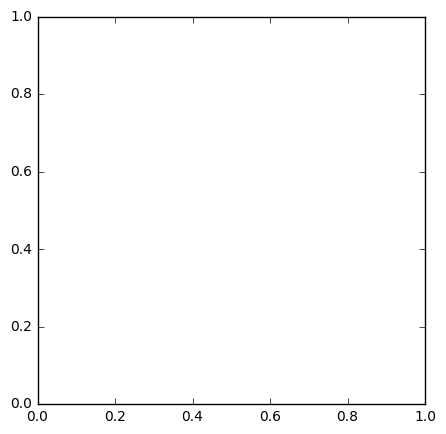

In [3]:
plt.figure(figsize=(11, 5))

plt.subplot(1, 2, 1)
print_sample_2(separable_sample)
plt.plot((-1, 1), (1, -1))

plt.subplot(1, 2, 2)
print_sample_2(nseparable_sample)

plt.show()

## Градиентный спуск

In [32]:
default_t = lambda t, k: 1 / np.sqrt(k + 1)

# Нахождение миниумума методом градиентного спуска
def find_min(x_0, f, grad, next_t=default_t, eps=1e-6, MAX_K = 1000):
    t = 0.5
    old_x = x_0
    k = 0
    
    while True:
        k += 1
        t = next_t(t, k)
        x = old_x - t * grad(old_x)
        if (np.abs(f(x) - f(old_x)) < eps / 2.) or k == MAX_K:
            break
        
        old_x = x
    
    return (old_x, k)

### Формулировка для разделяющей гиперплоскости
$\omega$ - уравнение плоскости (нулевую координату имеет свободный член), $x$ - точка с дополнительной нулевой координатой со значением $-1$. Утверждается, что точка минимума функции риска $Q(\omega) = \sum_{i=1}^{m} ln(1 + exp(-y_i \cdot <x_i, \omega>))$ есть искомая разделяющая прямая ($y_i$ - соответствующий класс точки).

$\frac{\delta Q}{\delta {\omega_i}} = \sum_{i=1}^{m} (1 - \frac{1}{1 + exp(-y_i \cdot <x_i, \omega>)}) \cdot (-y_i x_{i}^{k})$

In [16]:
def get_class(c):
    if c:
        return 1
    return -1


def raw_grad(omega, X, Y):
    values = []
    for k in range(len(omega)):
        value = np.sum([(1 - expit(Y[i] * np.sum(X[i] * omega))) * (-Y[i] * X[i][k]) for i in range(M)])
        values.append(value)
    
    return np.array(values)

    
def get_grad(X, Y):
    return lambda omega: raw_grad(omega, X, Y)

    
def raw_fun(X, Y, omega):
    values = []
    
    for i in range(M):
        value = np.logaddexp(0, -Y[i] * np.sum(X[i] * omega))
        values.append(value)
    
    return np.sum(values)


def get_fun(X, Y):
    return lambda omega: raw_fun(X, Y, omega)


def get_xy(sample):
    return sample[:, 1:], np.array([get_class(y[0]) for y in sample])


def get_equation(omega):
    return lambda x: np.sum(x * omega[1:]) - omega[0]


def get_a(omega):
    return np.array([-omega[2], omega[1]])


def get_points_2(omega):
    point = omega[0] * omega[1:]
    points = [point - 10 * get_a(omega), point + 10 * get_a(omega)]
    return np.array(points)

In [33]:
def test_gradient(sample, x0, next_t=default_t, max_k=100, x_lim=2, y_lim=2):

    X, Y = get_xy(sample)

    omega, k = find_min(x0, get_fun(X, Y), get_grad(X, Y), MAX_K=max_k)

    omega = omega / (omega[1] ** 2 + omega[2] ** 2) ** 0.5
    equation = get_equation(omega)

    plt.figure(figsize=(12, 8))
    print_sample_2(separable_sample)
    points = get_points_2(omega)
    plt.plot(points.T[0], points.T[1], 'g')

    plt.xlim(-x_lim, x_lim)
    plt.ylim(-y_lim, y_lim)
    plt.show()

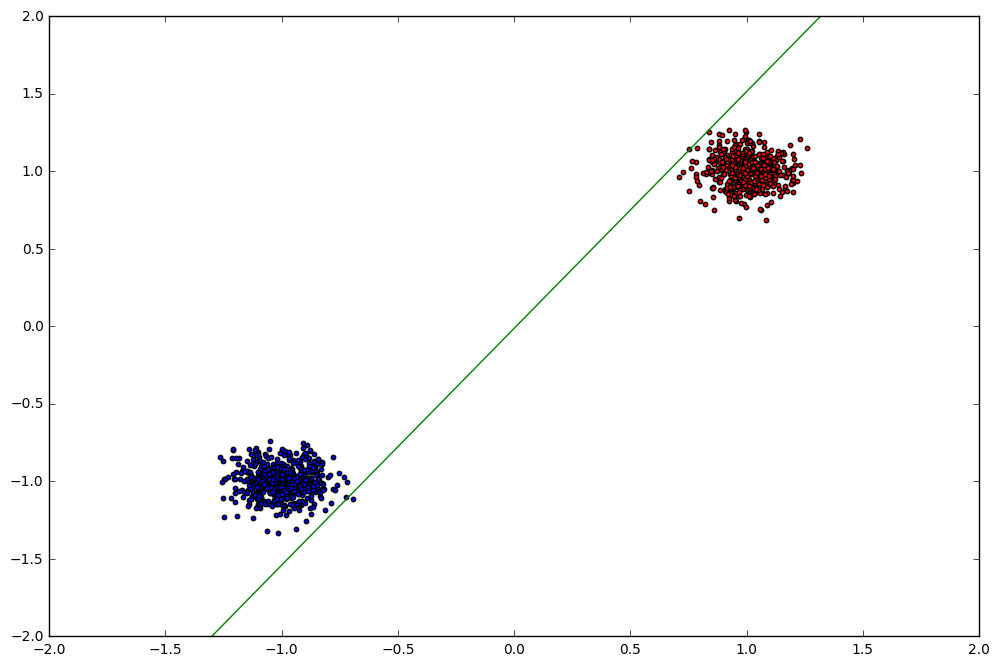

In [37]:
test_gradient(separable_sample, np.array([1, 1, -5000]), next_t=lambda t, k: t * 0.98, max_k=300)

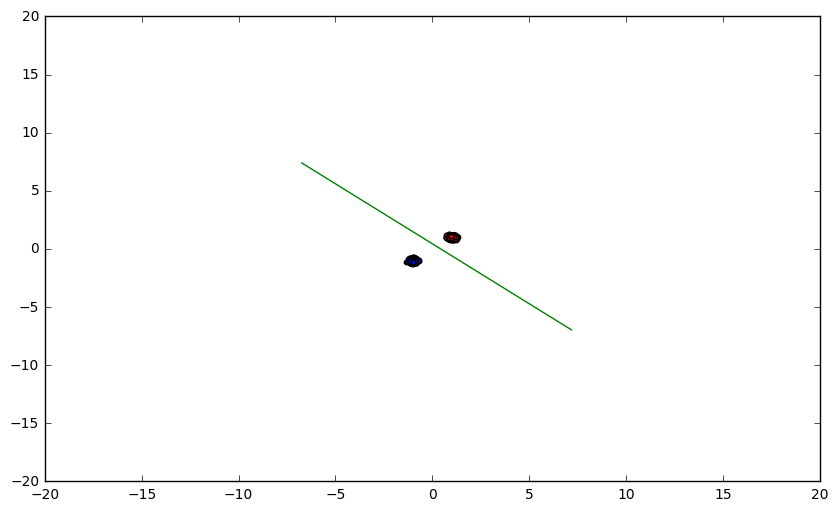

In [380]:
test_gradient(nseparable_sample, np.array([1, 1, 0]))